# Comparing *biVI* and *scVI* model results on five Allen samples

In [1]:
# System
import sys
sys.path.insert(0, '../BIVI/')

# Math
import numpy as np
import torch
device = 'cuda'
import pandas as pd
import pickle

# Plots
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

fs = 30
# colors
import matplotlib.colors as mcolors
sns.color_palette("Purples", as_cmap=True)
plt.set_cmap('Purples')

# scvi
import anndata
import scanpy as sc

from distributions import log_prob_NBuncorr, log_prob_poisson, log_prob_NBcorr
from nnNB_module import log_prob_nnNB

color_list = [sns.color_palette()[0], sns.color_palette("YlOrBr")[1],
              sns.color_palette("YlOrBr")[3],sns.color_palette("YlOrBr")[5]]

<Figure size 432x288 with 0 Axes>

In [2]:
def get_AIC(k,logL):
    ''' Return AIC given k parameters and logL of data.'''
    
    return(2*k-2*logL)
    
    
    

In [3]:
# load in results
results_dict_all = {}

allen_samples = ['A08','B01','C01','F08','H12']
models = ['scVI','Bursty','Constitutive','Extrinsic']

for name in allen_samples:
    results_file = open(f'../results/{name}_processed_hv_results_dict.pickle', 'rb')
    results_dict_ = pickle.load(results_file)
    results_file.close()
    results_dict_all[name] = results_dict_
    print(name)
    print(results_dict_['scVI-10-NAS_SHAPE']['params']['mean'].shape)
    print(results_dict_['scVI-10-NAS_SHAPE']['params']['mean'].shape[0]*.9)
    print(results_dict_['scVI-10-NAS_SHAPE']['params']['mean'].shape[0]*.1)


A08
(5938, 4000)
5344.2
593.8000000000001
B01
(7430, 4000)
6687.0
743.0
C01
(7627, 4000)
6864.3
762.7
F08
(6865, 4000)
6178.5
686.5
H12
(5424, 4000)
4881.6
542.4


In [4]:
## calculate AIC for all samples 
sample_list = []
model_list = []
k_list = []
AIC_list = []
timing_list = []
memory_usage_list = []
logL_list = []
N_cells_list = []
for sample in allen_samples:
    
    for model in models:
        train_logL_ = -results_dict_all[sample][f'{model}-10-NAS_SHAPE']['df_history']['reconstruction_error_train_set'][0]['reconstruction_loss_train'].values[-1]
        valid_logL_ = -results_dict_all[sample][f'{model}-10-NAS_SHAPE']['df_history']['reconstruction_error_test_set'][0]['reconstruction_loss_validation'].values[-1]
        logL_ = train_logL_+valid_logL_
        N_cells_ = results_dict_all[sample][f'{model}-10-NAS_SHAPE']['params']['mean'].shape[0]
        if model == 'scVI':
            k_ = 2*N_cells_*2000 + 2*2000
        elif model == 'Bursty':
            k_ = 2*N_cells_*2000 + 2000
        elif model == 'Constitutive':
            k_ = 2*N_cells_*2000
        elif model == 'Extrinsic':
            k_ = 2*N_cells_*2000 + 2000

        AIC_ = get_AIC(k_,logL_)
    
        sample_list.append(sample)
        model_list.append(model)
        k_list.append(k_)
        N_cells_list.append(N_cells_)
        AIC_list.append(AIC_)
        logL_list.append(logL_)
        timing_list.append(results_dict_all[sample][f'{model}-10-NAS_SHAPE']['runtime'][0])
        memory_usage_list.append(results_dict_all[sample][f'{model}-10-NAS_SHAPE']['memory_used'])


In [5]:
# plot AIC, runtime, and memory usage for the different models on the different datasets
# this addresses model selection -- how much better is biVI than scVI at describing the data
# or should i just use logL ? 

df_plot = pd.DataFrame({
    'Sample' : sample_list,
    'Model' : model_list,
    '# params' : k_list,
    'AIC' : AIC_list,
    'Runtime' : timing_list,
    'Memory usage' : memory_usage_list,
    'Memory usage (MB)' : np.array(memory_usage_list)/10**6,
    'Memory usage (GB)' : np.array(memory_usage_list)/10**9,
    'logL' : logL_list,
    'N_cells' : N_cells_list,
    'AIC_norm' : np.array(AIC_list)/np.array(N_cells_list),
    'logL_norm' : np.array(logL_list)/np.array(N_cells_list)
})


In [6]:
df_plot

,Sample,Model,# params,AIC,Runtime,Memory usage,Memory usage (MB),Memory usage (GB),logL,N_cells,AIC_norm,logL_norm
0,A08,scVI,23756000,4.751808e+07,166.169929,15308288,15.308288,0.015308,-3041.515625,5938,8002.371679,-0.512212
1,A08,Bursty,23754000,4.751404e+07,831.042331,15575552,15.575552,0.015576,-3022.047607,5938,8001.691495,-0.508934
2,A08,Constitutive,23752000,4.751123e+07,154.625812,15567360,15.567360,0.015567,-3614.326660,5938,8001.217355,-0.608677
3,A08,Extrinsic,23754000,4.751413e+07,179.008766,15575552,15.575552,0.015576,-3064.243652,5938,8001.705707,-0.516040
4,B01,scVI,29724000,5.945301e+07,200.807585,15308288,15.308288,0.015308,-2503.781494,7430,8001.750681,-0.336983
5,B01,Bursty,29722000,5.944892e+07,1017.694422,15575552,15.575552,0.015576,-2458.529663,7430,8001.200143,-0.330892
6,B01,Constitutive,29720000,5.944548e+07,186.868638,15567360,15.567360,0.015567,-2739.591797,7430,8000.737441,-0.368720
7,B01,Extrinsic,29722000,5.944901e+07,218.134853,15575552,15.575552,0.015576,-2503.686401,7430,8001.212298,-0.336970
8,C01,scVI,30512000,6.102925e+07,213.558643,15308288,15.308288,0.015308,-2622.815674,7627,8001.736676,-0.343886
9,C01,Bursty,30510000,6.102517e+07,1046.524480,15575552,15.575552,0.015576,-2584.275513,7627,8001.202118,-0.338833


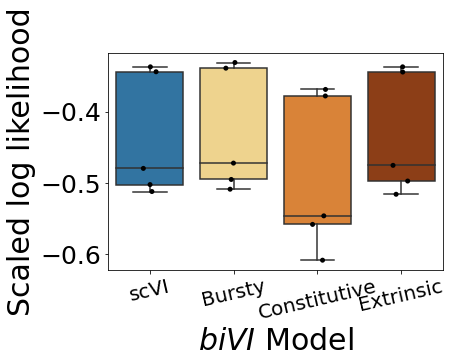

In [9]:
# and PLOT !!! 

save_path = None
metric = 'logL_norm'
ax = sns.boxplot(data=df_plot, x="Model", y=metric, palette = color_list)

sns.stripplot(data=df_plot, x="Model", y=metric,ax=ax, color = 'black')
plt.xlabel('$biVI$ Model',fontsize=fs)
plt.ylabel('Scaled log likelihood',fontsize=fs)
# plt.suptitle('Model selection',fontsize=fs)
# plt.ylim(0.,1)
plt.xticks(fontsize=20,rotation=13)
plt.yticks(fontsize=25)
# plt.ylim(0.25,0.7)

if save_path:
    plt.savefig(save_path,dpi=400,bbox_inches='tight')
    
    
    
    

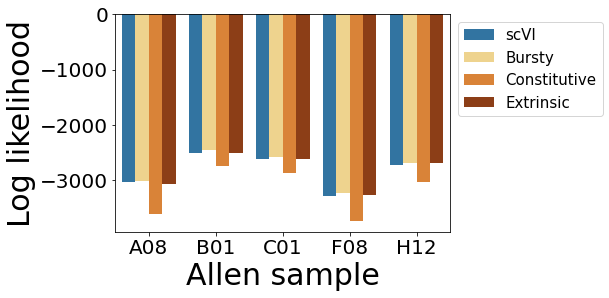

In [30]:
# and PLOT !!! 

save_path = None
metric = 'logL'
sns.barplot(data=df_plot, x="Sample", y=metric, hue = "Model" , palette = color_list)

plt.xlabel('Allen sample',fontsize=fs)
plt.ylabel('Log likelihood',fontsize=fs)
# plt.suptitle('Comparing models',fontsize=fs)
# # plt.ylim(0.,1)
# plt.xticks(fontsize=20,rotation=10)
# plt.yticks(fontsize=25)
# # plt.ylim(0.25,0.7)

plt.legend(bbox_to_anchor=[1.0, 1.0],fontsize=15)

if save_path:
    plt.savefig(save_path,dpi=400,bbox_inches='tight')

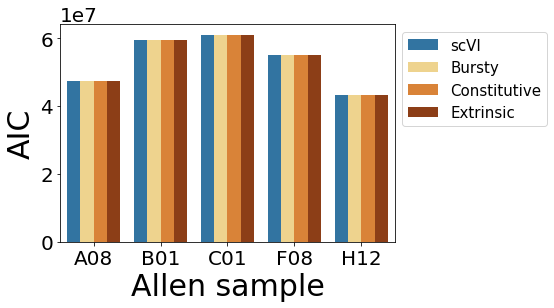

In [31]:
# and PLOT !!! 

save_path = None
metric = 'AIC'
sns.barplot(data=df_plot, x="Sample", y=metric, hue = "Model" , palette = color_list)

plt.xlabel('Allen sample',fontsize=fs)
plt.ylabel('AIC',fontsize=fs)
# plt.suptitle('Comparing models',fontsize=fs)
# # plt.ylim(0.,1)
# plt.xticks(fontsize=20,rotation=10)
# plt.yticks(fontsize=25)
# # plt.ylim(0.25,0.7)

plt.legend(bbox_to_anchor=[1.0, 1.0],fontsize=15)

if save_path:
    plt.savefig(save_path,dpi=400,bbox_inches='tight')

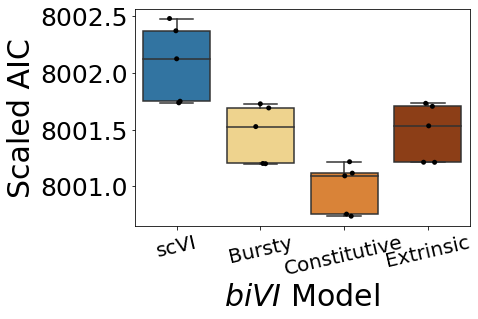

In [10]:
# and PLOT !!! 

save_path = None
metric = 'AIC_norm'
ax = sns.boxplot(data=df_plot, x="Model", y=metric, palette = color_list)

sns.stripplot(data=df_plot, x="Model", y=metric,ax=ax, color = 'black')
plt.xlabel('$biVI$ Model',fontsize=fs)
plt.ylabel('Scaled AIC',fontsize=fs)
# plt.suptitle('Model selection',fontsize=fs)
# plt.ylim(0.,1)
plt.xticks(fontsize=20,rotation=13)
plt.yticks(fontsize=25)
# plt.ylim(0.25,0.7)

if save_path:
    plt.savefig(save_path,dpi=400,bbox_inches='tight')
    
    
    

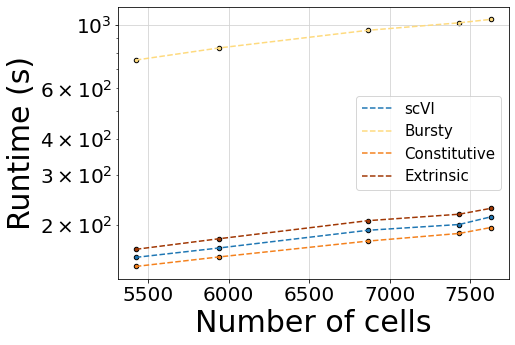

In [33]:
# plot timing for different methods vs number of cells

save_path = None

fig, ax = plt.subplots(1,1,figsize=(7,5))
for i,model in enumerate(models):
    df_plot_ = df_plot[df_plot['Model']==model]
    
    plt.scatter(df_plot_['N_cells'].values,df_plot_['Runtime'].values, s = 20, alpha = 1.0,
                edgecolor='black', color = color_list[i])
    plt.plot(np.sort(df_plot_['N_cells'].values),np.sort(df_plot_['Runtime'].values), linestyle='--',
             label=model, color = color_list[i])
    
plt.grid(color='lightgray')
plt.xlabel('Number of cells',fontsize=fs)
plt.ylabel('Runtime (s)',fontsize=fs)
plt.yscale('log')
plt.legend(fontsize=15)

if save_path:
    plt.savefig(save_path,dpi=400,bbox_inches='tight')
    
    

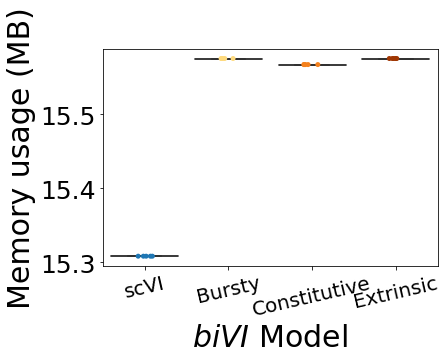

In [34]:
# plot memory usage for different methods -  why are they the same no matter the number of cells?
# this greatly confuses me ....... 

# and PLOT !!! 
save_path = None
ax = sns.boxplot(data=df_plot, x="Model", y="Memory usage (MB)",palette = color_list)

sns.stripplot(data=df_plot, x="Model", y="Memory usage (MB)",ax=ax,palette = color_list)
plt.xlabel('$biVI$ Model',fontsize=fs)
plt.ylabel('Memory usage (MB)',fontsize=fs)
# plt.suptitle('Comparing models',fontsize=fs)
# plt.ylim(0.,1)
plt.xticks(fontsize=20,rotation=13)
plt.yticks(fontsize=25)
# plt.ylim(0.25,0.7)

if save_path:
    plt.savefig(save_path,dpi=400,bbox_inches='tight')
    

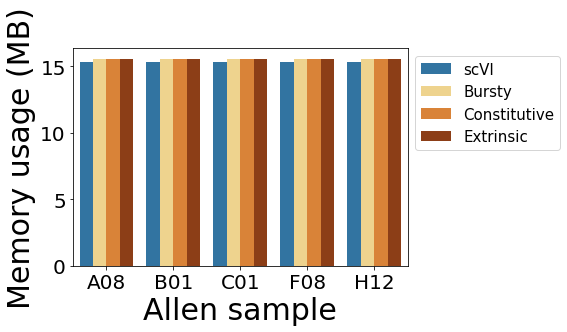

In [35]:
# and PLOT !!! 
save_path = None
metric = 'Memory usage (MB)'
sns.barplot(data=df_plot, x="Sample", y=metric, hue = "Model" ,palette = color_list)

plt.xlabel('Allen sample',fontsize=fs)
plt.ylabel('Memory usage (MB)',fontsize=fs)
# plt.suptitle('Comparing models',fontsize=fs)
# # plt.ylim(0.,1)
# plt.xticks(fontsize=20,rotation=10)
# plt.yticks(fontsize=25)
# # plt.ylim(0.25,0.7)

plt.legend(bbox_to_anchor=[1.0, 1.0],fontsize=15)

if save_path:
    plt.savefig(save_path,dpi=400,bbox_inches='tight')
    